## Part 1 - Exploratory Data Analysis

In [100]:
# BASIC PACKAGES
import pandas as pd
import numpy as np
import missingno as msno
from collections import Counter
from datetime import datetime

# VISUALIZATION PACKAGES
import scikitplot as skplt
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df1 = pd.read_json("logins.json")

In [11]:
#check for missing values
df1.isna().sum()

login_time    0
dtype: int64

In [68]:
#since no missing values, proceed with partitioning
df1['hour'] = df1.login_time.dt.hour
df1['15min_interval'] = [(int(i.minute / 15) + 1) * 15 for i in df1.login_time]

<AxesSubplot:title={'center':'Login Distribution by Interval'}, xlabel='hour,15min_interval', ylabel='Count'>

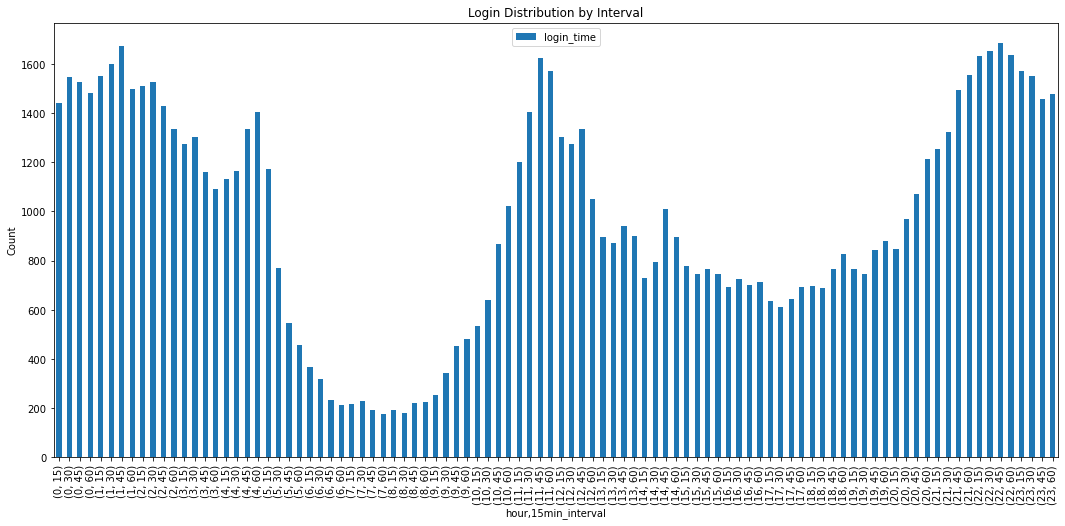

In [84]:
#plot counts of login times per 15 minute inteval
fig, axs = plt.subplots(figsize=(18, 8))
fig.patch.set_facecolor('white')
axs.set_xlabel('Count by 15-minute Interval')
axs.set_ylabel('Count')
axs.set_title('Login Distribution by Interval')
df1.groupby([df1["hour"], df1['15min_interval']]).count().plot(kind='bar', rot=90, ax=axs)

From the above, we can see that login traffic peaks primarily between the hours of 21:00 and 04:00, with another brief peak around 11:00. Significant lulls occur between 05:00 and 11:00 and again between 13:00 and 21:00. 

## Part 2 - Experiment metrics and Design 

1. I suppose that the underlying data not available in this exercise would show the location of drivers (which city) when they logged into the driver app to receive fares. As a success metric, I would evaluate the ratio of logins by city by driver. In pre-experiment data, it is descrived that there is a strong bias of each driver ID in terms of what city they log in from. I would expect to see a lop-sided ratio per driver, on average, and so to measure the success of the experiment, we would want to see that ratio become more balanced, especially on weekends when both cities have reasonable activity, and the metric should be approaching a 50/50 split if possible. 
2. If we have data on the 'home city' of each driver, then we can assemble a table to measure the effectiveness of the experiment. Fares taken by drivers in their home city and fares taken by drivers in their 'away' city. This test would be indifferent to the home city of the drivers, and assumes the population sizes are similar. If not, we would have to run two sets of tests for the population of drivers from each city. Our null hypothesis would be that paying for the bridge tolls for a group of drivers would not affect their ratios of 'home fares' to 'away fares'. We could use any amount of historical data, in 2 week increments (to support our coming A-B test) to get a baseline of what p-values we should expect, or that is, what variation occurs in the data by chance.
3. To gather data necessary to reject or suppor the null hypothesis, we can perform an A-B test, giving 'toll immunity' to some portion of the population(s) of drivers and monitor for 2 weeks. Our driver population without toll reimbursement is our control group, and our driver population with reimbursed tolls is our test group. After 2 weeks, we can compare the data between our test and control group. Did our values vary with statistical significance between our test and control groups? If our p-value of the A-B test data is <0.05, we can confidently say that the experiment did affect the driver behavior.
4. If the results of the A-B are positive, that the experiment did confidently affect driver behavior, my recommendations to the city ops teams would be to then seriously consider the scope of the difference. Significance testing does not indicate the magnitude of the difference, only that the difference is statistically significant. Further consideration would have to be given to the results in deciding whether the cost of the experiment achieved the desired results or not, and if so, how to then move forward with full-scale implementation.

## Part 3 - Predictive Modeling

In [85]:
df2 = pd.read_json('ultimate_data_challenge.json')

In [86]:
df2.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9


In [87]:
df2.shape

(50000, 12)

In [89]:
df2.dtypes

city                       object
trips_in_first_30_days      int64
signup_date                object
avg_rating_of_driver      float64
avg_surge                 float64
last_trip_date             object
phone                      object
surge_pct                 float64
ultimate_black_user          bool
weekday_pct               float64
avg_dist                  float64
avg_rating_by_driver      float64
dtype: object

<AxesSubplot:title={'center':'Missing Values'}, xlabel='Columns', ylabel='Percentage / Count'>

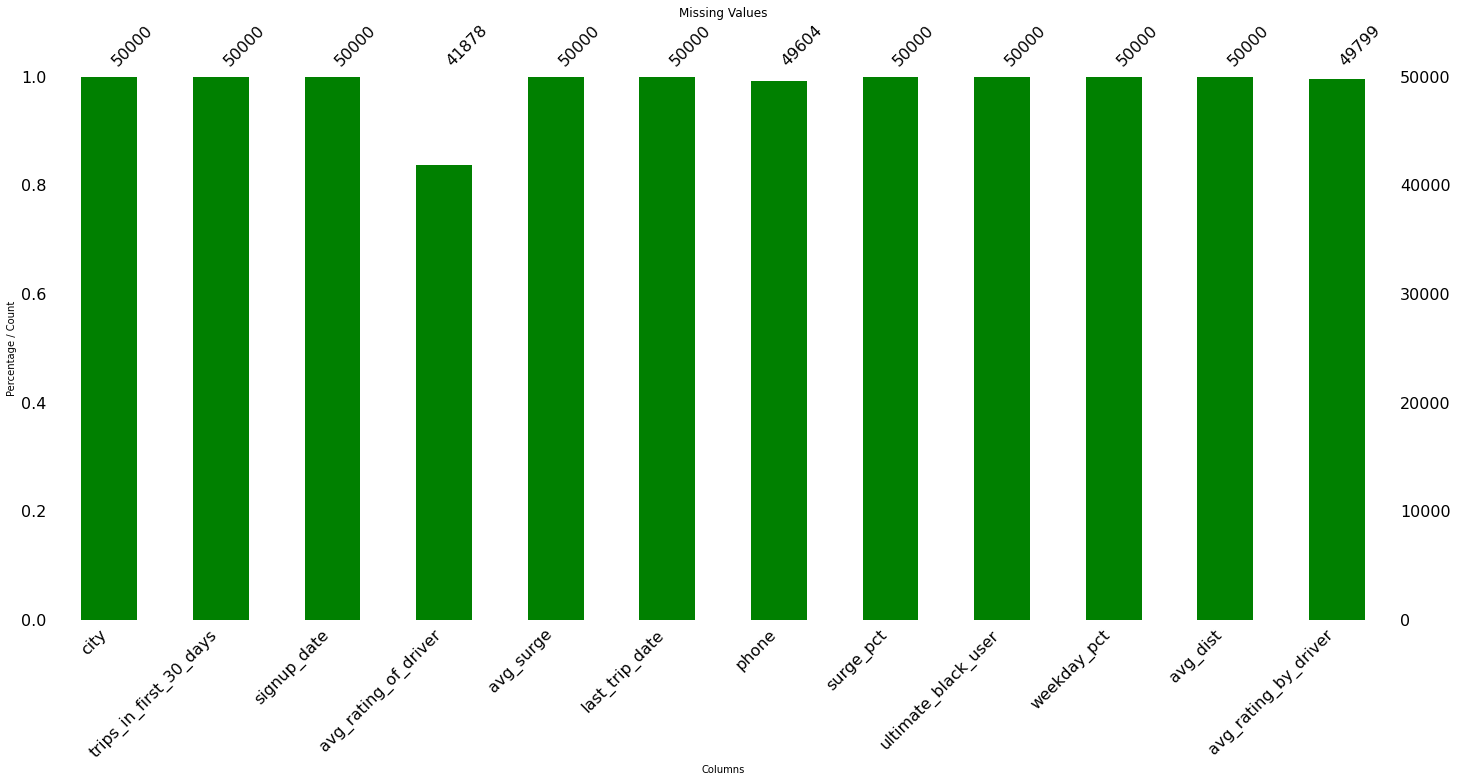

In [95]:
fig, ax = plt.subplots()
fig.patch.set_facecolor('white')
ax.set_xlabel('Columns')
ax.set_ylabel('Percentage / Count')
ax.set_title('Missing Values')
msno.bar(df2, color='green')

In [183]:
#fill missing values in avg ratings with mean()
df2.avg_rating_of_driver.fillna(df2.avg_rating_of_driver.median(), inplace=True)
df2.avg_rating_by_driver.fillna(df2.avg_rating_by_driver.median(), inplace=True)

In [184]:
#convert last_trip_date to datetime object
df2['last_trip_date'] = pd.to_datetime(df2['last_trip_date'])

In [185]:
#check distribution of months in the dataset
df2.last_trip_date.dt.month.value_counts()

6    18256
1    10147
5     7585
4     4588
3     4568
2     4308
7      548
Name: last_trip_date, dtype: int64

In [186]:
#check most recent date, to understand when data was pulled
df2.last_trip_date.max()

Timestamp('2014-07-01 00:00:00')

Since the most recent trip data seems to indicate the data was pulled on Jul-01, we will count back 31 days and include all of June and Jul-01 as 'retained'

In [187]:
#add column for the binary target variable
df2['retained'] = 0
for i in range(len(df2.retained)):
    if (df2.last_trip_date[i].month == 6) or (df2.last_trip_date[i].month == 7):
        df2.retained[i] = 1

C:\Users\DP185257\AppData\Local\Temp/ipykernel_4476/1505254081.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2.retained[i] = 1


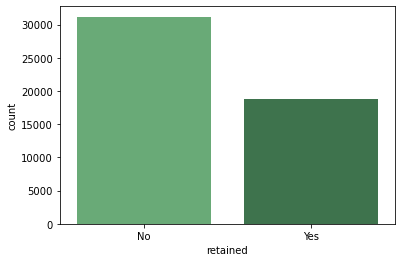

In [188]:
fig = plt.figure()
fig.patch.set_facecolor('white')
ax = sns.countplot(x='retained', data=df2, palette='Greens_d')
ax.xaxis.set_ticklabels(['No', 'Yes']);
plt.show()

We can see that approximately 38% of the customers from January were retained

In [189]:
#EDA on churned vs retained users

print('Avg trips in first 30 days for churned users:', 
      round(df2[df2['retained'] == 0].trips_in_first_30_days.mean(),2))
print('Avg trips in first 30 days for retained users:', 
      round(df2[df2['retained'] == 1].trips_in_first_30_days.mean(),2))

Avg trips in first 30 days for churned users: 1.66
Avg trips in first 30 days for retained users: 3.31


Retained users were utilizing ride services at double the rate in their first month when compared to users who eventually churned

In [190]:
print('Avg rating given to drivers by churned users:', 
      round(df2[df2['retained'] == 0].avg_rating_of_driver.mean(),2))
print('Avg rating given to drivers by retained users:', 
      round(df2[df2['retained'] == 1].avg_rating_of_driver.mean(),2))

Avg rating given to drivers by churned users: 4.67
Avg rating given to drivers by retained users: 4.62


There does not seem to be any notable relationship here. Churned users did not get a far worse set of drivers than retained users

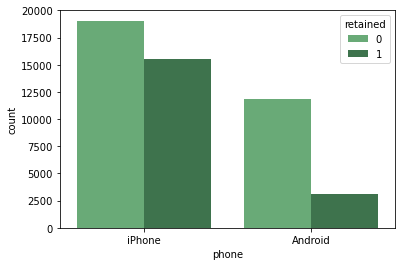

In [191]:
fig = plt.figure()
fig.patch.set_facecolor('white')
ax = sns.countplot(x='phone', hue='retained', data=df2, palette='Greens_d')

Looks like users on Android churned at a much higher rate than users on iPhone. Perhaps the Android app is buggy or suffers from poor UX

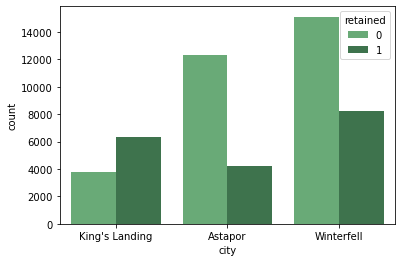

In [192]:
fig = plt.figure()
fig.patch.set_facecolor('white')
ax = sns.countplot(x='city', hue='retained', data=df2, palette='Greens_d')

Looks like users from Astapor and Winterfell churned at a much higher rate than users from King's Landing

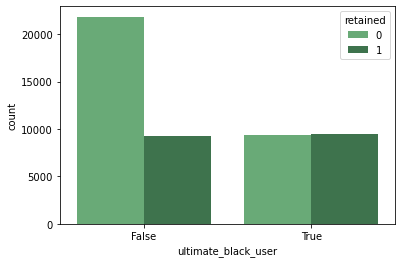

In [193]:
fig = plt.figure()
fig.patch.set_facecolor('white')
ax = sns.countplot(x='ultimate_black_user', hue='retained', data=df2, palette='Greens_d')

It seems when users took an Ultimate Black ride in their first 30 days, their churn rate improved dramatically. It must be quite impressive for users to experience that. 

#### Pre-processing

In [194]:
def encode_and_bind(original_dataframe, feature_to_encode):
    dummies = pd.get_dummies(original_dataframe[feature_to_encode])
    res = pd.concat([original_dataframe, dummies], axis=1)
    res = res.drop([feature_to_encode], axis=1)
    return(res) 

In [195]:
df3 = encode_and_bind(encode_and_bind(df2, 'city'), 'phone').drop(['signup_date','last_trip_date'], axis=1)
df3

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,retained,Astapor,King's Landing,Winterfell,Android,iPhone
0,4,4.7,1.10,15.4,True,46.2,3.67,5.0,1,0,1,0,0,1
1,0,5.0,1.00,0.0,False,50.0,8.26,5.0,0,1,0,0,1,0
2,3,4.3,1.00,0.0,False,100.0,0.77,5.0,0,1,0,0,0,1
3,9,4.6,1.14,20.0,True,80.0,2.36,4.9,1,0,1,0,0,1
4,14,4.4,1.19,11.8,False,82.4,3.13,4.9,0,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,0,5.0,1.00,0.0,False,100.0,5.63,4.2,1,0,1,0,0,1
49996,1,4.9,1.00,0.0,False,0.0,0.00,4.0,0,1,0,0,0,1
49997,0,5.0,1.00,0.0,True,100.0,3.86,5.0,0,0,0,1,1,0
49998,2,3.0,1.00,0.0,False,100.0,4.58,3.5,0,1,0,0,0,1


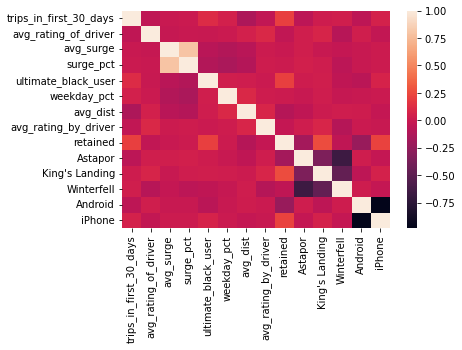

In [204]:
sns.heatmap(df3.corr());

From the above, we see confirmation of what we already found-- positive correlations in retained customers and customers from Kings Landing, customer with iPhone, customers who took an Ultimate Black in their first 30 days, and customers who took more trips in general in their first 30 days

In [196]:
# SPLIT DEPENDENT AND INDEPENDENT VARIABLES INTO X, Y

X = df3.drop('retained', axis=1)
y = df3['retained']
print(X.shape)
print(y.shape)

(50000, 13)
(50000,)


In [201]:
# MODELING PACKAGES
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

In [198]:
#Split data into Train and Test sets

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=123)
print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(37500, 13) (12500, 13)
(37500,) (12500,)


In [199]:
rf_model= RandomForestClassifier(random_state=123)
rf_model.fit(X_train, y_train)
y_pred_rf= rf_model.predict(X_test)

In [202]:
print(classification_report(y_test,y_pred_rf))

              precision    recall  f1-score   support

           0       0.80      0.82      0.81      7754
           1       0.69      0.66      0.67      4746

    accuracy                           0.76     12500
   macro avg       0.74      0.74      0.74     12500
weighted avg       0.76      0.76      0.76     12500



This basic random forest model shows an 82% recall score for churned customers, or ability to predict churned customers correctly. Let's use it to predict which customers may leave in the next month, from the remaining non-churned customers we have

In [212]:
df_retain= df3[df3['retained'] == 1].drop('retained', axis=1)
df_retain.reset_index(inplace=True, drop=True)
df_retain

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,Astapor,King's Landing,Winterfell,Android,iPhone
0,4,4.7,1.10,15.4,True,46.2,3.67,5.0,0,1,0,0,1
1,9,4.6,1.14,20.0,True,80.0,2.36,4.9,0,1,0,0,1
2,2,3.5,1.00,0.0,True,100.0,10.56,5.0,0,0,1,0,1
3,0,4.0,1.38,50.0,False,50.0,3.04,5.0,0,1,0,0,1
4,1,5.0,1.00,0.0,True,50.0,10.86,3.0,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
18799,0,2.0,1.00,0.0,False,100.0,2.39,4.0,0,1,0,0,1
18800,1,4.5,1.00,0.0,False,50.0,2.53,5.0,0,1,0,0,1
18801,0,5.0,1.25,100.0,False,0.0,1.06,5.0,0,0,1,0,1
18802,3,4.8,1.11,11.1,True,55.6,2.53,4.7,1,0,0,0,1


In [213]:
y_pred_churn= rf_model.predict(df_retain)

In [214]:
df_retain['retain?'] = y_pred_churn

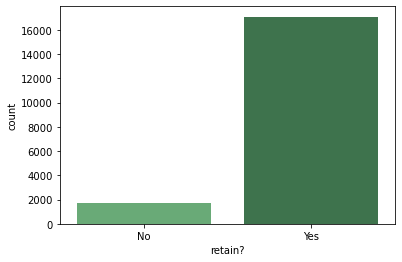

In [217]:
fig = plt.figure()
fig.patch.set_facecolor('white')
ax = sns.countplot(x='retain?', data=df_retain, palette='Greens_d')
ax.xaxis.set_ticklabels(['No', 'Yes']);
plt.show()

This is a very basic decision tree model, which should be able to handle the amount of features involved quite nicely. Other model types that could be used here might include LogisticRegressor or SVM. Concerns I would have about the model is the score is not great, and future scope could include engineering several more features using the data. 

The business insights I would focus on from this analysis would be what we learned about the positive correlation between retained users and what phone they use, how many rides they took in their first month, whether they took an Ultimate Black in their first month, and what town they're in. For each of these, some strategy could be employed to improve rider retention.
1. Investigate the Android app for UX consistency with iPhone, and for app stability. Something in the app is detering user engagement.
2. Investigate why customers from King's Landing are much more likely to be retained. Are there more or better drivers in King's Landing? Are routes better optimized due to town infrastructure? 
3. 